In [79]:
import pandas as pd
import torch 
import botorch
import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np
#import manifold_utils
from manifold.clients.python import ManifoldClient
from io import BytesIO
from datetime import timedelta

In [80]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.facecolor'] = 'white'

In [81]:
# Moving into the repository
import os

repo_name = "SustainableConcrete"
# modify to point to local repository location
repo_dir = "/home/jkusuma/concrete/" + repo_name
#if not os.getcwd()[-len(repo_name) :] == repo_name:
os.chdir(repo_dir)
os.getcwd()

'/home/jkusuma/concrete/SustainableConcrete'

In [82]:
import sys

if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    sys.path.append("/home/jkusuma/concrete/SustainableConcrete/")
    sys.path.append("/data/users/sebastianament/github/SustainableConcrete/")

import importlib

import models
import utils

In [83]:
importlib.reload(utils)
from utils import load_concrete_strength

verbose = True
# verbose = False

# Load data and partition into the right X and Y frames

In [84]:
data_path = "~/concrete/SustainableConcrete/data/compressive_strength_12-7-2023.csv"
df_temp = pd.read_csv(data_path, delimiter=",")

In [85]:
# rename dataframe labels to reflect new functions
df = df_temp.rename(columns={'Name' : 'Mix Name', 'Cement': 'Cement (kg/m3)', 'Fly Ash' : 'Fly Ash (kg/m3)', 'Slag' : 'Slag (kg/m3)', 'Water' : 'Water (kg/m3)', 'HRWR' : 'HRWR (kg/m3)', 'Fine Aggregate' : 'Fine Aggregate (kg/m3)'})
df['Coarse Aggregates (kg/m3)'] = 0
df['Material Source'] = 0
df['Temp (C)'] = 22
df['Clay'] = 0

In [86]:
# define which columns of the data we are using as inputs to the model
X_columns = [
    "Cement (kg/m3)",
    "Fly Ash (kg/m3)",
    "Slag (kg/m3)",
    "Water (kg/m3)",
    "HRWR (kg/m3)",
    "Fine Aggregate (kg/m3)",
    "Coarse Aggregates (kg/m3)",
#    "Clay0 (kg/m3)",
#    "Clay1 (kg/m3)",
#    "Clay2 (kg/m3)",
    "Material Source",
    "Temp (C)",
    "Time",
]

In [87]:
# first define the bounds of the search space
_TOTAL_BINDER_NAMES = [
    "Cement (kg/m3)",
    "Fly Ash (kg/m3)",
    "Slag (kg/m3)",
    "Clay0 (kg/m3)",
    "Clay1 (kg/m3)",
    "Clay2 (kg/m3)",
]

bounds_dict = {
    # NOTE: the pure cement baseline is outside of these bounds (~752), as is Dec_2022_2 (~211)
    # "Cement": (300, 700),
    # "Fly Ash": (0, 350),
    # "Slag": (0, 450),
    # "Coarse Aggregate": (800, 1950),
    # "Fine Aggregate": (600, 1700),
    # "Time": (0, 28),  # up to 28 days
    # "Cement (kg/m3)": (200, 900),
    "Cement (kg/m3)": (50, 900),
    "Fly Ash (kg/m3)": (0, 700),
    "Slag (kg/m3)": (0, 700),
    "Clay0 (kg/m3)": (0, 150),
    "Clay1 (kg/m3)": (0, 150),
    "Clay2 (kg/m3)": (0, 150),
    "Water (kg/m3)": (100, 600),
    "HRWR (kg/m3)": (0.0, 20.0),
    "MRWR (kg/m3)": (0.0, 20),
    "VMA (oz/cwt)": (0.0, 10),  # TODO: determine this
    "AE (oz/cwt)": (0.0, 10),  # TODO: determine this
    "Fine Aggregate (kg/m3)": (400, 1800),
    "Coarse Aggregates (kg/m3)": (0, 2000),
    "Material Source": (0, 1),
    # "w/b": (0.2, 0.5),
    "Temp (C)": (4.5, 22),
    "Time": (0, 28),  # up to 28 days
}

# bounds_dict = {
#     # updated to the new data format for uiuc 2024
#     "Cement (kg/m3)": (0, 950),
#     "Fly Ash (kg/m3)": (0, 950),
#     "Slag (kg/m3)": (0, 950),
#     "Clay0 (kg/m3)": (0, 950),
#     "Clay1 (kg/m3)": (0, 950),
#     "Clay2 (kg/m3)": (0, 950),
#     "Water (kg/m3)": (100, 400),
#     "HRWR (kg/m3)": (0, 20),
#     "HRWR (kg/m3)": (0, 20),
#     "Fine Aggregate (kg/m3)": (400, 2000),
#     "Coarse Aggregates (kg/m3)": (0, 2000),
#     "Material Source": (0, 1),
#     "Temp (C)": (-20, 40),
#     "Time": (0, 28),  # up to 28 days
# }

min_binder, max_binder = 0, 0
for name in _TOTAL_BINDER_NAMES:
    min_binder += bounds_dict[name][0]
    max_binder += bounds_dict[name][1]

# bounds_dict.update( # fix relative to binder ratios
#    {
#        "Water (kg/m3)": (0.2 * min_binder, 0.5 * max_binder),
#        "HRWR (kg/m3)": (0, 0.1 * max_binder),  # linear constraint also applies, see below
#        "MRWR (kg/m3)": (0, 0.1 * max_binder),  # linear constraint also applies, see below
#    }
# )

bounds = torch.tensor([bounds_dict[col] for col in X_columns]).T
if verbose:
    print("The lower and upper bounds for the respective variables are set to:")
    for col, bound in zip(X_columns, bounds.T):
        print(f"\t- {col}: [{bound[0].item()}, {bound[1].item()}]")
    print()

The lower and upper bounds for the respective variables are set to:
	- Cement (kg/m3): [50.0, 900.0]
	- Fly Ash (kg/m3): [0.0, 700.0]
	- Slag (kg/m3): [0.0, 700.0]
	- Water (kg/m3): [100.0, 600.0]
	- HRWR (kg/m3): [0.0, 20.0]
	- Fine Aggregate (kg/m3): [400.0, 1800.0]
	- Coarse Aggregates (kg/m3): [0.0, 2000.0]
	- Material Source: [0.0, 1.0]
	- Temp (C): [4.5, 22.0]
	- Time: [0.0, 28.0]



In [88]:
# pass the df loaded from manifold directly into the load_concrete_strength function to partition into the right X and Y columns for ML

data = load_concrete_strength(
    df,
    mix_name_column="Mix Name",
    verbose=verbose,
    X_columns=X_columns,
    process_batch_names_from_mix_name=True,
    bounds_dict=bounds_dict,
)

The data has 268 rows and 23 columns, which are:
	- Mix ID
	- Mix Name
	- Description
	- Cement (kg/m3)
	- Fly Ash (kg/m3)
	- Slag (kg/m3)
	- Clay0
	- Water (kg/m3)
	- HRWR (kg/m3)
	- Fine Aggregate (kg/m3)
	- Time
	- GWP
	- Strength1 (psi)
	- Strength2 (psi)
	- Strength3 (psi)
	- Strength (Mean)
	- Strength (Std)
	- # of measurements
	- Curing Temp (°C)
	- Coarse Aggregates (kg/m3)
	- Material Source
	- Temp (C)
	- Clay

There are 4 columns with missing entries:
missing_col_ind=tensor([False, False, False, False,  True, False, False, False, False, False,
         True,  True,  True])
data_columns=array(['Cement (kg/m3)', 'Fly Ash (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'HRWR (kg/m3)', 'Fine Aggregate (kg/m3)',
       'Coarse Aggregates (kg/m3)', 'Material Source', 'Temp (C)', 'Time',
       'GWP', 'Strength (Mean)', 'Strength (Std)'], dtype='<U25')
n_missing=tensor([ 0,  0,  0,  0, 28,  0,  0,  0,  0,  0,  4, 22, 22])
	- HRWR (kg/m3) has 28 missing entries.
	- GWP has 4 miss

In [89]:
# distribution of w/b ratios
# plt.hist(df["Water (kg/m3)"] / (
#     df["Cement (kg/m3)"] + df["Fly Ash (kg/m3)"] + df["Slag (kg/m3)"]
# ))

# Implement learning algorithm based on partitioned X and Y frames

In [90]:
# data is a SustainableConcreteDataset object
# NOTE: Could add 3-day strength
model_strength_days = [
    1,
    28,
]  # the strength days that are converted to optimization objectives
model = models.SustainableConcreteModel(strength_days=model_strength_days)
model.fit_gwp_model(data)
model.fit_strength_model(data, use_fixed_noise=False)

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([ 50.0000,   0.0000,   0.0000,  35.0000,   0.0000, 400.0000,   0.0000,
          0.0000,   4.5000]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           0.0000,    0.0000,   22.0000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([9.0000e+02, 7.0000e+02, 7.0000e+02, 4.7500e+02, 9.5000e+01, 1.8000e+03,
        2.0000e+03, 1.0000e+00, 2.2000e+01]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,    0.,    0.,   22.],
       dtype=torch.float64))


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): LogTransformedInterval(1.000E-06, 1.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): MaternKernel(
          (raw_lengthscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+03)
        )
        (raw_outputscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+02)
      )
      (1): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+03)
        )
        (raw_outputscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+02)
      )
    )
  )
  (outcome_transform): Standardize()
  (input_transform): ChainedInputTransform(
    (tf1): AffineInputTransform()
    (tf2): Log10()
    (tf3): Normalize()
  )
)

In [91]:
model.strength_model.likelihood.noise

tensor([0.0868], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [92]:
model_list = model.get_model_list()

In [93]:
# NOTE: the original search space bounds are not satisfied by some of the data.
X, Y, Yvar, X_bounds = data.gwp_data
ind = range(len(X))
post_list = model_list.posterior(X)

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([ 50.0000,   0.0000,   0.0000,  35.0000,   0.0000, 400.0000,   0.0000,
          0.0000,   4.5000]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           0.0000,    0.0000,   22.0000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([9.0000e+02, 7.0000e+02, 7.0000e+02, 4.7500e+02, 9.5000e+01, 1.8000e+03,
        2.0000e+03, 1.0000e+00, 2.2000e+01]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,    0.,    0.,   22.],
       dtype=torch.float64))


[torch.Size([59, 1]), torch.Size([59])]

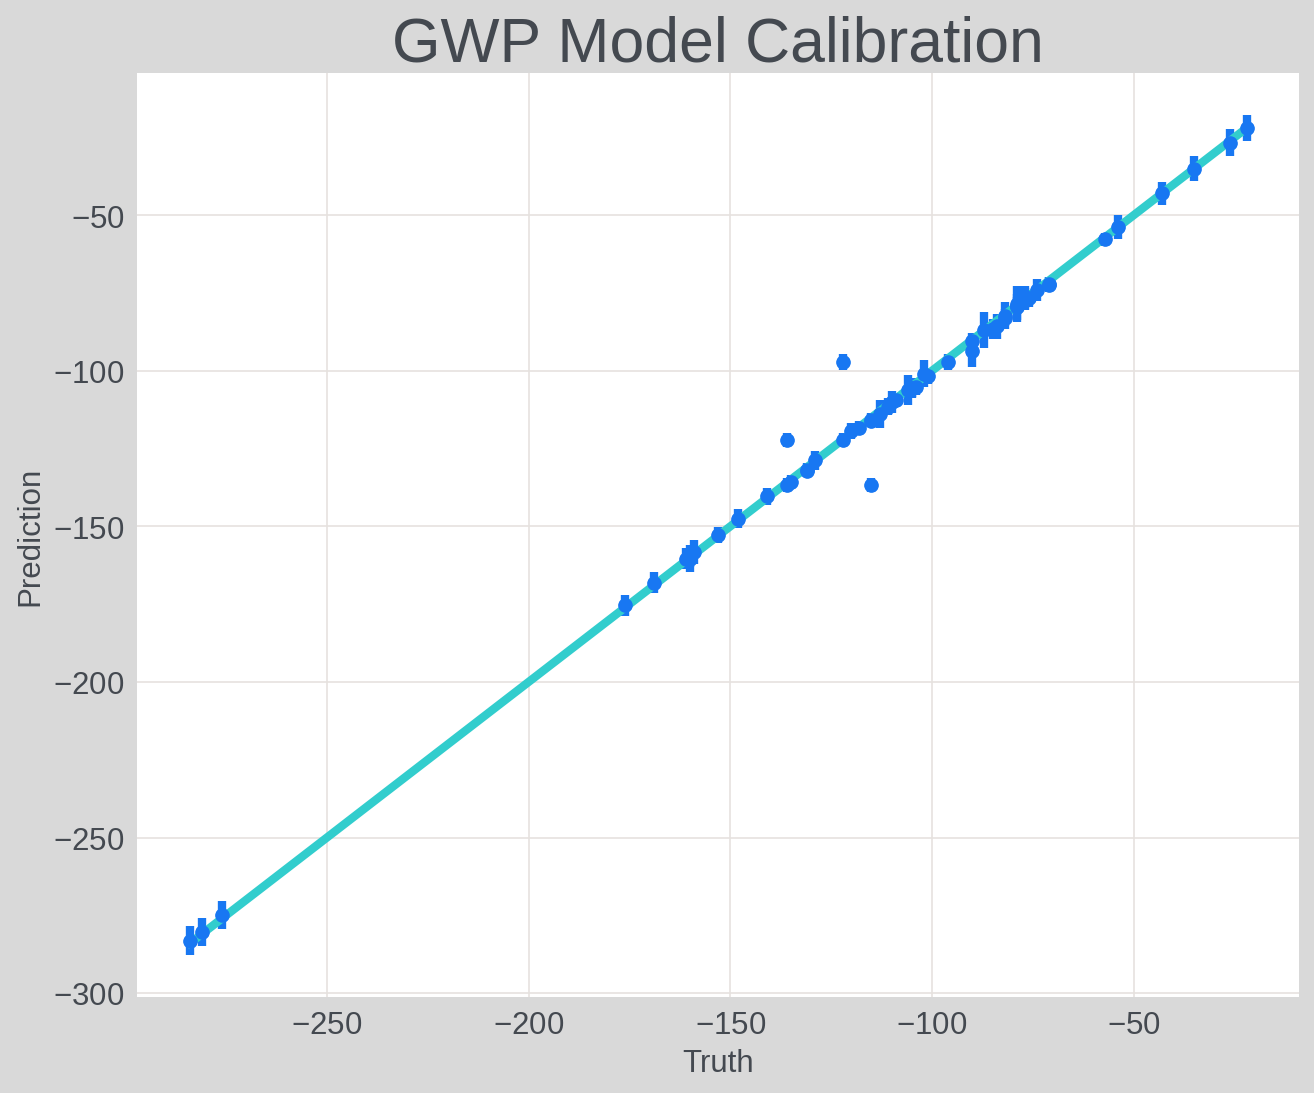

In [94]:
# CHECK_gwp = 1

# if CHECK_gwp:
obj_id = 0  # 0 is GWP, 1 is 1 day, 2, is 28-day strength
# Y[ind], post_list.mean[:, 0], Yvar[ind], post_list.variance[:, obj_id] # variance for GWP looking good, since it gets rounded to ~ 1%.
truth = Y[ind]
pred = post_list.mean[:, obj_id].detach()
# truth_std = Yvar[ind][ind].sqrt().detach()
pred_std = post_list.variance[:, obj_id].sqrt().detach()
plt.figure(dpi=150)
plt.title("GWP Model Calibration")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.scatter(truth, pred)
plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o")
line = torch.arange(truth.min(), truth.max())
plt.plot(line, line)

[truth.shape, pred.shape]

In [95]:
X, Y, Yvar = data.strength_data_by_time(1)
ind = range(len(X))
post_list = model_list.posterior(X[..., :-1])
Y.shape

torch.Size([60, 1])

[torch.Size([60, 1]), torch.Size([60])]

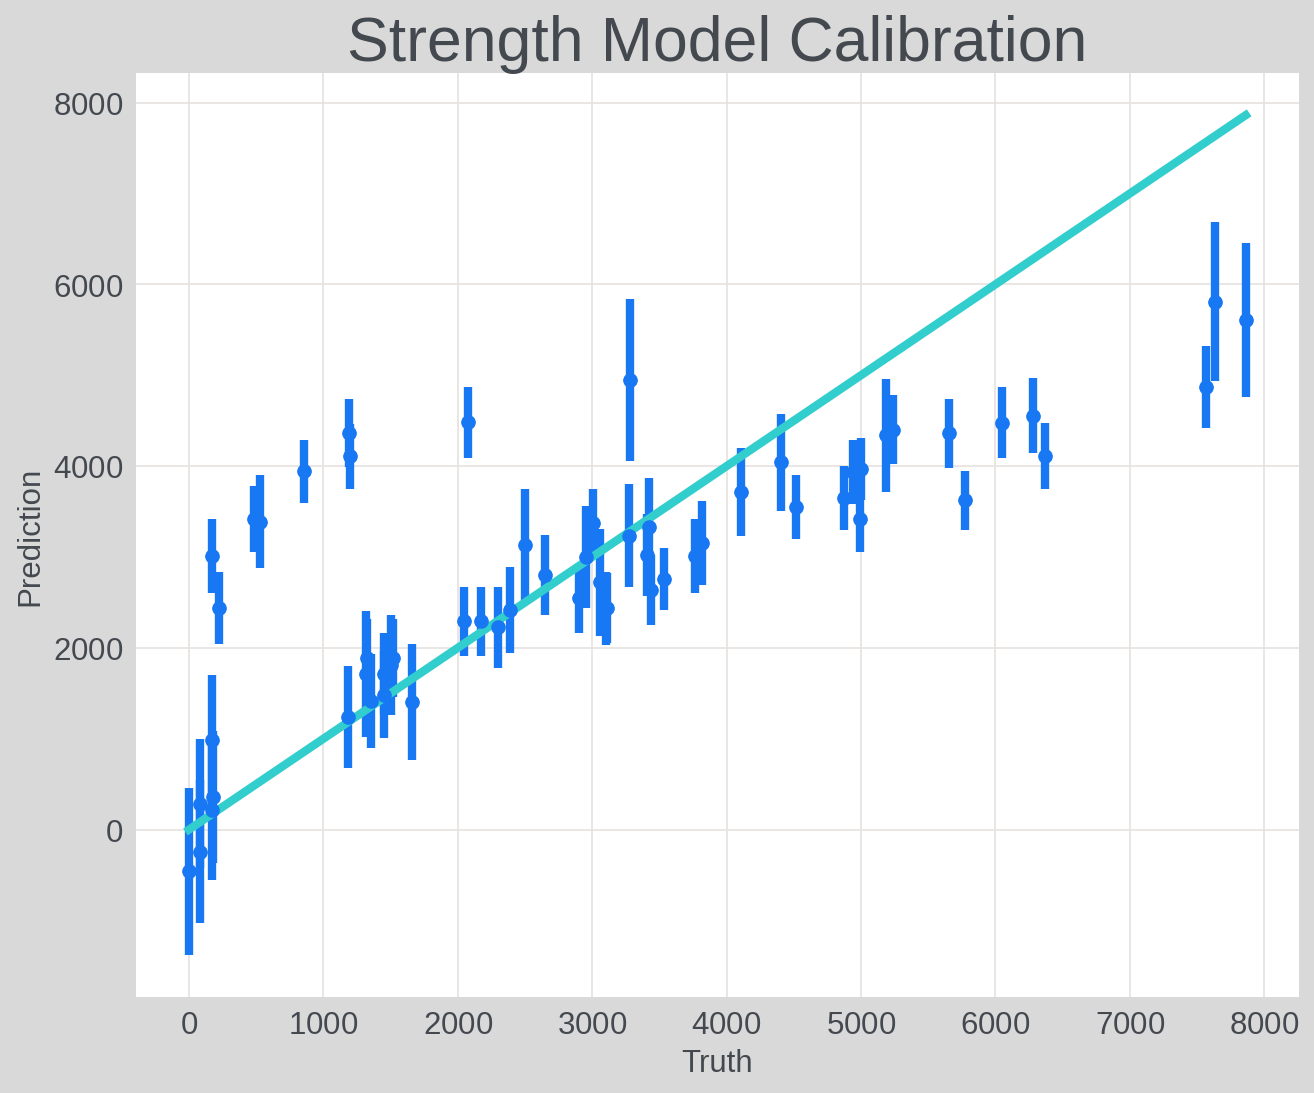

In [96]:
# CHECK_gwp = 1

# if CHECK_gwp:
obj_id = 1  # 0 is GWP, 1 is 1 day, 2, is 28-day strength
# Y[ind], post_list.mean[:, 0], Yvar[ind], post_list.variance[:, obj_id] # variance for GWP looking good, since it gets rounded to ~ 1%.
truth = Y[ind]
pred = post_list.mean[:, obj_id].detach()
# truth_std = Yvar[ind][ind].sqrt().detach()
pred_std = post_list.variance[:, obj_id].sqrt().detach()
plt.figure(dpi=150)
plt.title("Strength Model Calibration")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.scatter(truth, pred)
plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o")
line = torch.arange(truth.min(), truth.max())
plt.plot(line, line)

[truth.shape, pred.shape]

In [97]:
# CHECK_1day = 1

# if CHECK_1day:
time = 14
Xt, truth, truth_var = data.strength_data_by_time(time)
truth_std = truth_var.sqrt()
obj_id_post = 2  # 0 is GWP, 1 is 1 day, 2, is 28-day strength
# truth = data.Y[row_ind, obj_id][ind]
pred = post_list.mean[:, obj_id_post].detach()

# truth_std = data.Yvar[row_ind, obj_id][ind].sqrt()
pred_std = post_list.variance[:, obj_id_post].sqrt().detach()

#    fig = plt.figure(dpi=200)
#    plt.title(f"Day-{time} Strength Calibration")
#    plt.ylabel("Prediction")
#    plt.xlabel("Truth")
#    plt.scatter(truth[1:18], pred)
#    lw = 3
#    plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o", linewidth=lw)
#    plt.errorbar(truth.squeeze(), pred, xerr=2 * truth_std.squeeze(), fmt="o", linewidth=lw/2)
#    line = torch.arange(truth.min(), truth.max())
#    plt.plot(line, line, color="black", linestyle=":")
#    plt.show()

[truth.shape, pred.shape]  # truth value has more rows than predictions

[torch.Size([0, 1]), torch.Size([60])]

# GWP and Curve prediction

In [98]:
X_columns

['Cement (kg/m3)',
 'Fly Ash (kg/m3)',
 'Slag (kg/m3)',
 'Water (kg/m3)',
 'HRWR (kg/m3)',
 'Fine Aggregate (kg/m3)',
 'Coarse Aggregates (kg/m3)',
 'Material Source',
 'Temp (C)',
 'Time']

In [99]:
## Example 1: Select a mix in the data set that we want to plot
X = data.gwp_data[0]
mix_ind = 2  # this selects which mix from the database we want to plot
mix_ind = 16  # this M100
mix_ind = 4  # this M100
X_plot = X[[mix_ind]]  # follows: cement, fly ash, slag, water, HRWR, fine agg
## Example 2: manually specify the composition
manual_specify = False
if manual_specify:
    X_plot_dict = {
        "Cement (kg/m3)": 200.65,  # cement
        "Fly Ash (kg/m3)": 172.58,  # fly ash
        "Slag (kg/m3)": 293.44,  # slag
        "Water (kg/m3)": 233.33,  # water
        "HRWR (kg/m3)": 0.891,  # HRWR
        "Fine Aggregate (kg/m3)": 611.11,  # fine agg
        "Coarse Aggregates (kg/m3)": 1175.58,  # coarse agg
        "Clay0 (kg/m3)": 0,
        "Clay1 (kg/m3)": 0,
        "Clay2 (kg/m3)": 0,
        "Material Source": 1,  
        "Temp (C)": 22,  # room temperature
    }
    X_plot[0, :] = torch.tensor([X_plot_dict[col] for col in X_columns[:-1]])

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([ 50.0000,   0.0000,   0.0000,  35.0000,   0.0000, 400.0000,   0.0000,
          0.0000,   4.5000]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           0.0000,    0.0000,   22.0000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([9.0000e+02, 7.0000e+02, 7.0000e+02, 4.7500e+02, 9.5000e+01, 1.8000e+03,
        2.0000e+03, 1.0000e+00, 2.2000e+01]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,    0.,    0.,   22.],
       dtype=torch.float64))


In [100]:
X_plot.shape

torch.Size([1, 9])

In [101]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


## Run GWP prediction
def plot_strength_curve(
    model,
    Xs_plot,
    plot_uncertainties: bool = True,
    observed_data=None,
    observed_times=None,
    color_1="green",
    color_2="blue",
    label_1="Predictions",
    label_2="Observations",
    title="Predicted Mix",
    xlim=(0.15, 30),
    ylim=(0, 12000),
    figsize=(6, 6),
    dpi=150,
    create_fig: bool = True,
):
    # GWP prediction
    gwp_pred = model.gwp_model.posterior(Xs_plot).mean

    ## Run strength curve prediction
    # define time sampling intervals
    t_start, t_stop = 0.2, 28.0
    num_t = 1024  # default value is 1024
    plot_times = torch.arange(t_start, t_stop, step=(t_stop - t_start) / num_t)

    # plot_times = torch.tensor([0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 28.0])
    # num_t = plot_times.size(dim=0)
    tableau = list(mcolors.TABLEAU_COLORS.values())

    if create_fig:
        plt.figure(dpi=dpi, figsize=figsize)

    for i in range(Xs_plot.shape[0]):
        X_plot = Xs_plot[[i]]

        # adding time dimension to composition inputs
        X_w_time = torch.cat(
            (X_plot.expand(num_t, X_plot.shape[-1]), plot_times.unsqueeze(-1)), dim=-1
        )

        # call strength curve prediction
        curve_post = model.strength_model.posterior(X_w_time)
        curve_mean = curve_post.mean.detach().squeeze()
        curve_std = curve_post.variance.sqrt().detach().squeeze()

        ## Generate plot
        # color_1 = "green"
        color_1 = tableau[i]

        plt.title(title)  #  + f" with GWP = {-gwp_pred.round(decimals=2).item()}")
        plt.plot(plot_times, curve_mean, color=color_1)
        plt.ylabel("Strength")
        plt.xlabel("Time (Days)")
        nsigma = 2
        # plot uncertainties or not
        if plot_uncertainties:
            plt.fill_between(
                plot_times,
                curve_mean - nsigma * curve_std,
                curve_mean + nsigma * curve_std,
                alpha=0.2,
                label=f"Predictions {i}",
                color=color_1,
            )

        # if the mix is in the dataset, could grab the observed strength data ("observed_data") from Y
        if observed_data is not None:
            plt.plot(
                observed_times, observed_data, "o", label="Observations", c=color_1
            )
            plt.legend()

        plt.xscale("log")
        special_times = [6 / 24, 1, 3, 5, 7, 14, 28]
        special_labels = [
            "6 hours",
            "1 day",
            "3 days",
            "5 days",
            "7 days",
            "14 days",
            "28 days",
        ]
        plt.xticks(special_times, special_labels, rotation=50)
        plt.grid(visible=True)

        xlim = (0.15, 30)
        ylim = (0, 12000)
        plt.xlim(xlim)
        plt.ylim(ylim)

In [102]:
X = data.gwp_data[0]
X_test = X[[-3]]
dict(zip(X_columns, X_test.T))

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([ 50.0000,   0.0000,   0.0000,  35.0000,   0.0000, 400.0000,   0.0000,
          0.0000,   4.5000]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           0.0000,    0.0000,   22.0000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([9.0000e+02, 7.0000e+02, 7.0000e+02, 4.7500e+02, 9.5000e+01, 1.8000e+03,
        2.0000e+03, 1.0000e+00, 2.2000e+01]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,    0.,    0.,   22.],
       dtype=torch.float64))


{'Cement (kg/m3)': tensor([180.], dtype=torch.float64),
 'Fly Ash (kg/m3)': tensor([0.], dtype=torch.float64),
 'Slag (kg/m3)': tensor([325.], dtype=torch.float64),
 'Water (kg/m3)': tensor([180.], dtype=torch.float64),
 'HRWR (kg/m3)': tensor([0.], dtype=torch.float64),
 'Fine Aggregate (kg/m3)': tensor([1375.], dtype=torch.float64),
 'Coarse Aggregates (kg/m3)': tensor([0.], dtype=torch.float64),
 'Material Source': tensor([0.], dtype=torch.float64),
 'Temp (C)': tensor([22.], dtype=torch.float64)}

In [103]:
X_plot = X_test
X_plot.shape

torch.Size([1, 9])

In [104]:
X_plot[:, 4]

tensor([0.], dtype=torch.float64)

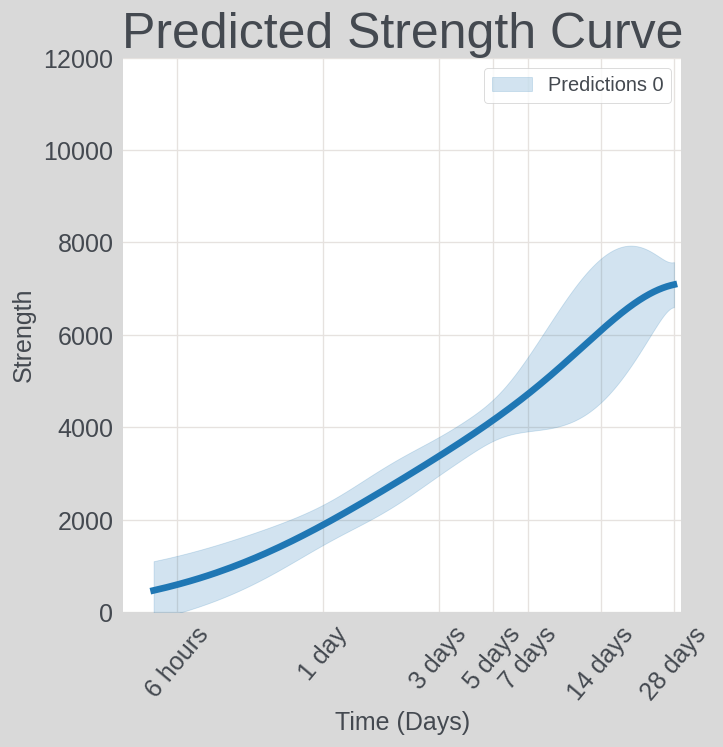

In [105]:
plot_strength_curve(
    model,
    X_plot,
    title="Predicted Strength Curve",
    dpi=120,
    create_fig=True,
)
plt.legend()